In [2]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [ "{:08b}".format(int(el, base=16)) for el in msg]
    return "".join(msg)


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [ "{:02x}".format(int(el, 2)) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = "{:08b}".format(image[i])
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

# Zadanie 1

Decoded message: 
Pwr to najlepsza uczelnia techniczna w Polsce i nikt nie powie mi, że jest inaczej



Text(0.5, 1.0, 'Image with message')

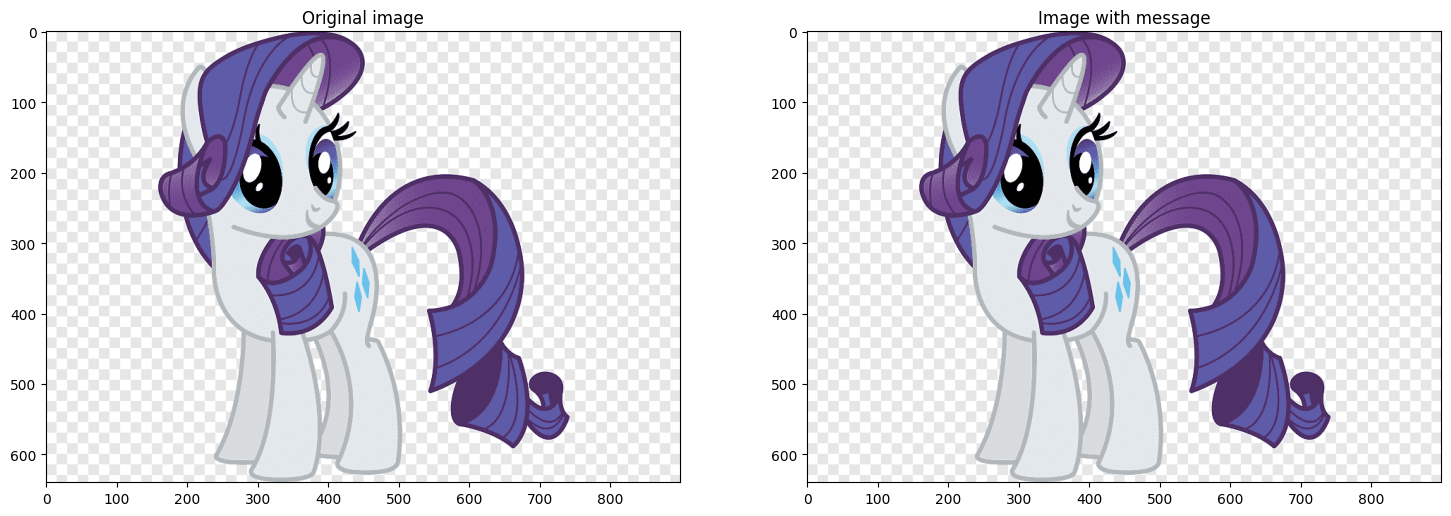

In [10]:
msg = """
Pwr to najlepsza uczelnia techniczna w Polsce i nikt nie powie mi, że jest inaczej
"""
nbits = 1
img = load_image("images/kucyk.png")

encoded_msg = encode_as_binary_array(msg)
img_msg = hide_message(img, encoded_msg, nbits)  

save_image("images/kucyk_msg.png", img_msg)

img_msg = load_image("images/kucyk_msg.png")
secret_message = decode_from_binary_array(reveal_message(img_msg, nbits, length=len(binary)))

print(f'Decoded message: {secret_message}')
f, ar = plt.subplots(1, 2)
ar[0].imshow(img)
ar[0].set_title("Original image")

ar[1].imshow(img_msg)
ar[1].set_title("Image with message")

# Zadanie 2

In [44]:
dimensions = img.shape
length = dimensions[0] * dimensions[1] * dimensions[2] # width, height, RGB
new_msg = "Patyk" * (length // 50) #  (4/5 / (5 * 8))
new_encoded_msg = encode_as_binary_array(new_msg)

print(len(new_encoded_msg) / length)

imgs_msg = []
for index in range(1, 9):
    imgs_msg.append(hide_message(img, new_encoded_msg, index))

mse_arr = np.zeros(8)

for x in range(0, len(img)):
    for y in range(0, len(img[0])):
        for index in range(0, 8):
            mse_arr[index] += (float(img[x][y][0]) - float(imgs_msg[index][x][y][0])) **2
            mse_arr[index] += (float(img[x][y][1])-float(imgs_msg[index][x][y][1])) **2
            mse_arr[index] += (float(img[x][y][2])-float(imgs_msg[index][x][y][2])) **2
            
mse_arr /= length

0.8


C:\Users\kacpe\AppData\Local\Temp\ipykernel_14848\1855038322.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(414)


Text(0, 0.5, 'MSE')

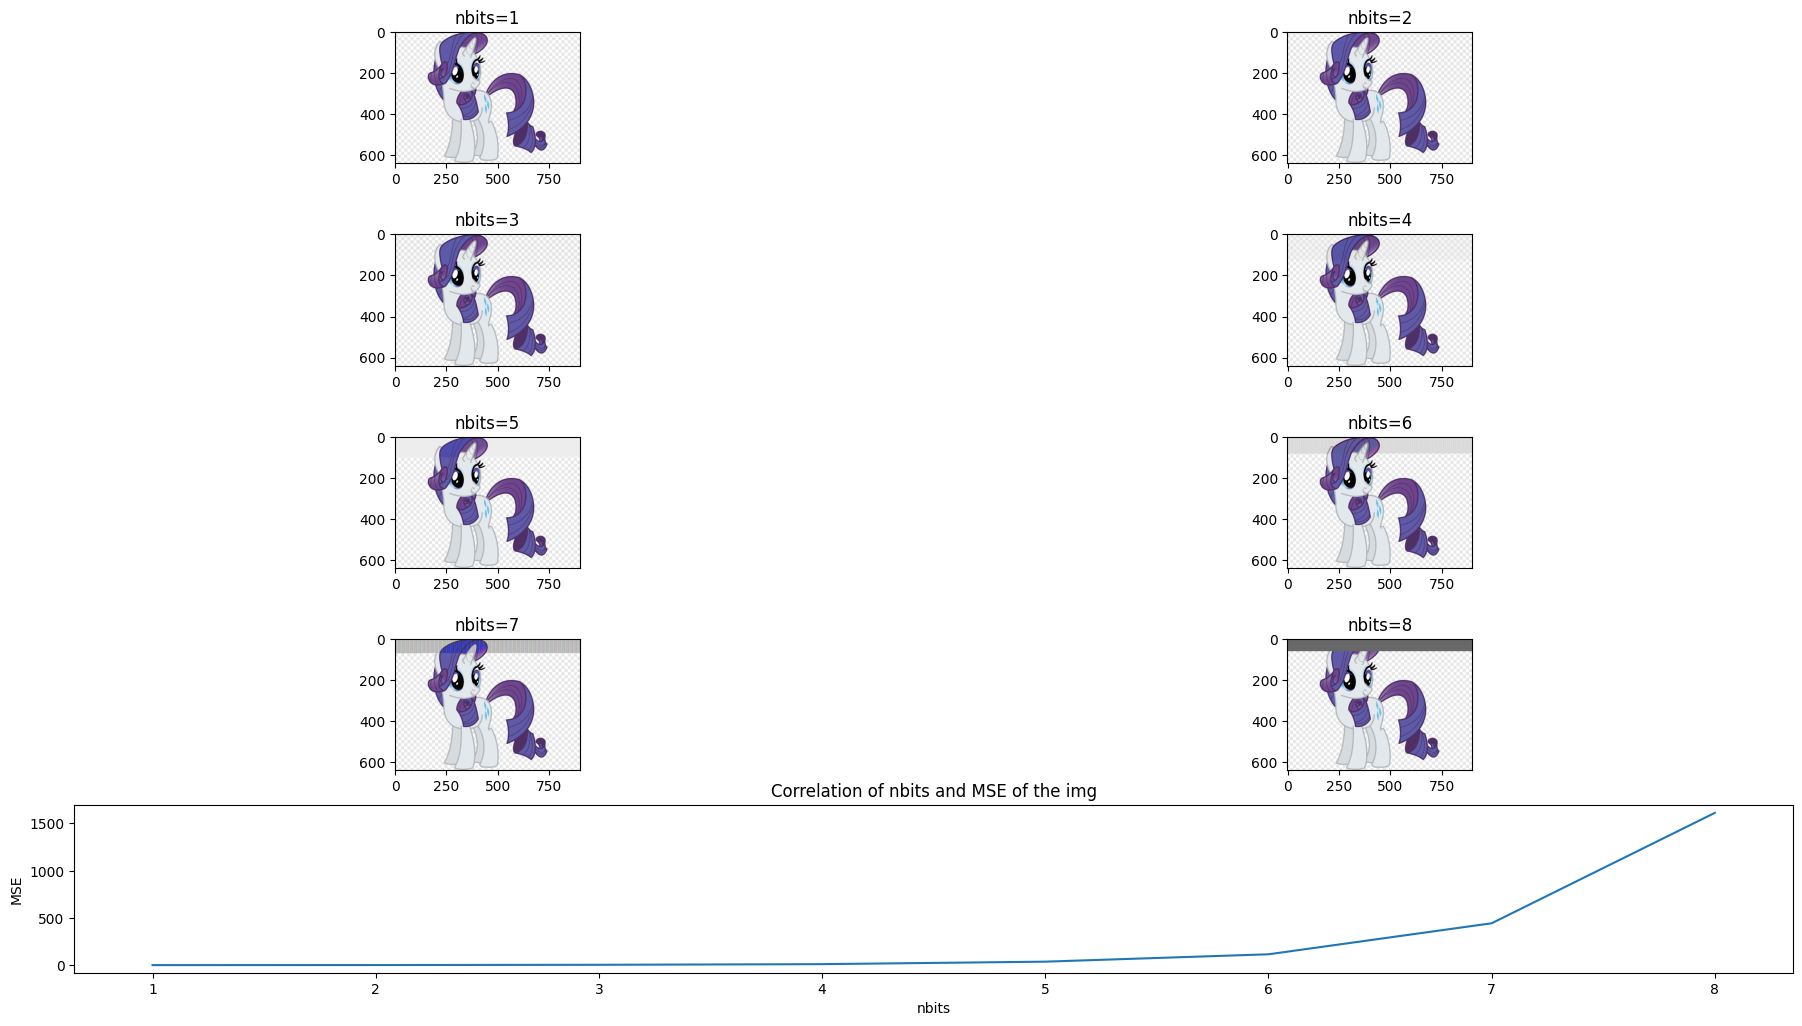

In [45]:
fig, ax = plt.subplots(5, 2)
fig.tight_layout(h_pad=3)

ax[0, 0].set_title("nbits=1")
ax[0, 0].imshow(imgs_msg[0])

ax[0, 1].set_title("nbits=2")
ax[0, 1].imshow(imgs_msg[1])

ax[1, 0].set_title("nbits=3")
ax[1, 0].imshow(imgs_msg[2])

ax[1, 1].set_title("nbits=4")
ax[1, 1].imshow(imgs_msg[3])

ax[2, 0].set_title("nbits=5")
ax[2, 0].imshow(imgs_msg[4])

ax[2, 1].set_title("nbits=6")
ax[2, 1].imshow(imgs_msg[5])

ax[3, 0].set_title("nbits=7")
ax[3, 0].imshow(imgs_msg[6])

ax[3, 1].set_title("nbits=8")
ax[3, 1].imshow(imgs_msg[7])

plt.subplot(414)
plt.plot([1,2,3,4,5,6,7,8], mse_arr)
plt.title("Correlation of nbits and MSE of the img")
plt.xlabel('nbits')
plt.ylabel('MSE')

# Zadanie 3

In [60]:
def my_hide_message(image, message, nbits=1, spos=0):
    """
    Hide a message in an image (LSB).
    
    nbits: number of least significant bit
    spos: starting position for encoding message
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > (len(image) - spos) * nbits:
        raise ValueError("Message is to long :(")
    
    if spos >= image.size:
        raise ValueError(f'Spos: {spos} is out of bounds for img size: {image.size}')
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = "{:08b}".format(image[i + spos])
        new_byte = byte[:-nbits] + chunk
        image[spos + i] = int(new_byte, 2)
        
    return image.reshape(shape)
    
def my_reveal_message(image, nbits=1, length=0, spos=0):
    """
    Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    spos: starting position of the message
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = "{:08b}".format(image[i + spos])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message


Pwr to najlepsza uczelnia techniczna w Polsce i nikt nie powie mi, że jest inaczej



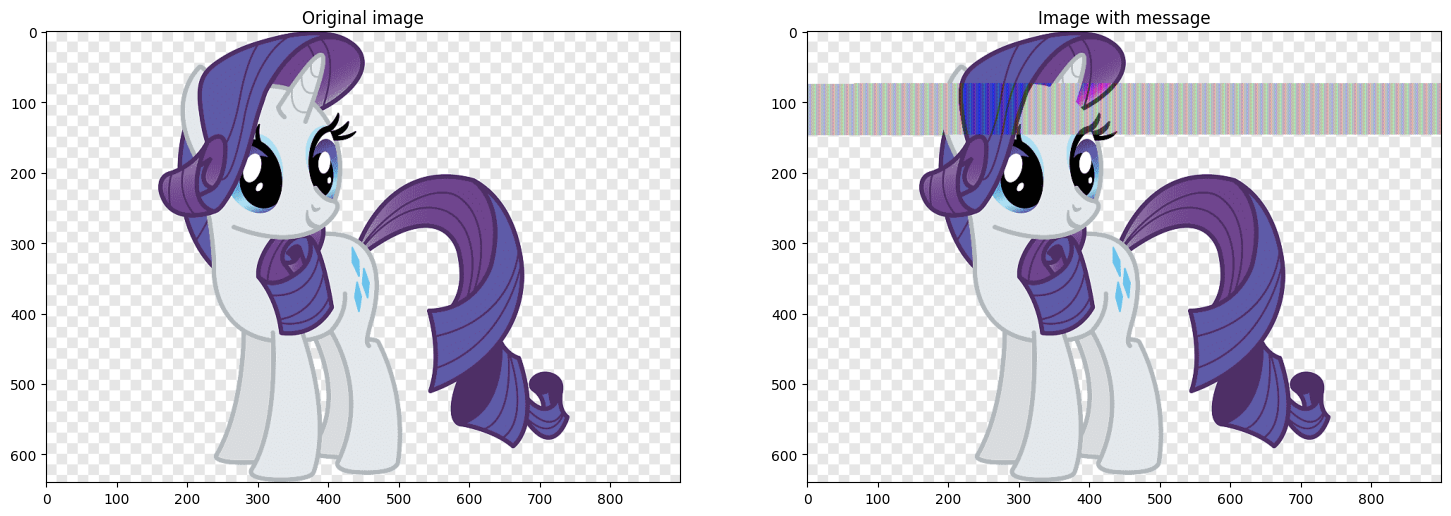

In [64]:
new_new_img_msg = my_hide_message(img, new_encoded_msg, 7, 200000)  
secret_msg = decode_from_binary_array(my_reveal_message(new_new_img_msg, 8, length=len(new_encoded_msg), spos=200000))

print(secret_message)

f, ar = plt.subplots(1, 2)
ar[0].set_title("Original image")
ar[0].imshow(img)

ar[1].set_title("Image with message")
ar[1].imshow(new_new_img_msg)

# Zadanie 4

In [95]:
def hide_image(image, secret_image_path, nbits=1):
    with open(secret_image_path, "rb") as file:
        secret_img = file.read()
        
    secret_img = secret_img.hex()
    secret_img = [secret_img[i:i + 2] for i in range(0, len(secret_img), 2)]
    secret_img = ["{:08b}".format(int(el, base=16)) for el in secret_img]
    secret_img = "".join(secret_img)
    
    return hide_message(image, secret_img, nbits), len(secret_img)


def reveal_image(image, length=0, nbits=1):
    bin_secret = reveal_message(image, nbits, length)
    bin_secret = [bin_secret[i:i+8] for i in range(0, len(bin_secret), 8)]    
    bin_secret = [ "{:02x}".format(int(el, 2)) for el in bin_secret]
    bin_secret = "".join(bin_secret)
     
    secret_img = binascii.unhexlify(bin_secret)
    
    return secret_img

Text(0.5, 1.0, 'Secret')

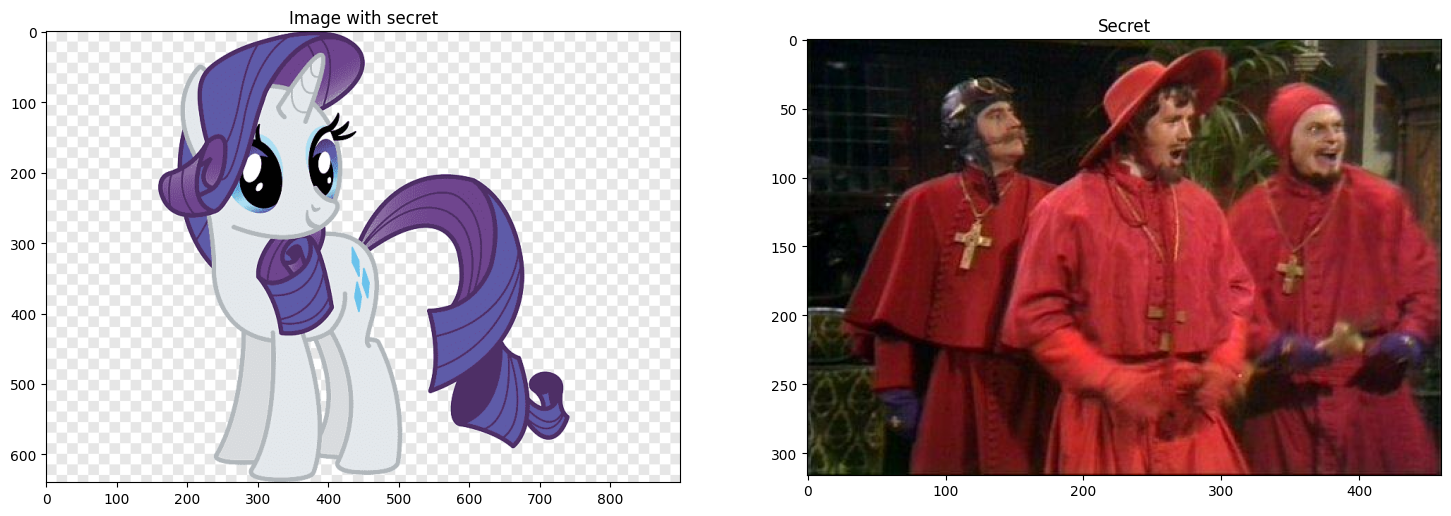

In [99]:
image = load_image("images/kucyk.png")

image_with_secret, length_of_secret = hide_image(image, "images/spanish.jpg", 1)
revealed = reveal_image(image_with_secret, length_of_secret, 1)  

with open("images/my_hidden_spanish.png", "wb") as file:
    file.write(revealed)
    
decoded = load_image("images/my_hidden_spanish.png")

f, ax = plt.subplots(1,2)

ax[0].imshow(image_with_secret)
ax[0].set_title("Image with secret")

ax[1].imshow(decoded)
ax[1].set_title("Secret")

# Zadanie 5

In [ ]:
#
# tu umieść kod
#